# Day2宿題 - 鈴木雅彦

## ライブラリとファイルの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import log_loss # 分類問題における性能評価に関する関数
from sklearn.metrics import accuracy_score # 〃
from sklearn.metrics import precision_score # 〃
from sklearn.metrics import recall_score # 〃
from sklearn.metrics import confusion_matrix # 〃


from sklearn.preprocessing import MinMaxScaler # 正規化
from sklearn.preprocessing import StandardScaler # 標準化

In [2]:
df = pd.read_csv(
    './data/ks-projects-201612.csv',
    encoding = "Windows-1252"
)

/Users/suzukimasahiko/anaconda3/envs/skillupai-ml-tokyo8-20181023/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 汎化性能の確認

In [3]:
# 実験用のデータを用意する
df2 = df[df['state '].isin(['successful', 'failed'])]
df2 = df2.head(1000)
df2['state'] = df2['state '] == 'successful'
df2 = df2.rename(columns={'goal ': 'goal', 'backers ': 'backers'})
df2 = df2[['state', 'goal', 'backers']]# pledgedを使ったら正解率1.0になってしまうので封印
df2 = df2.astype({'goal': float, 'backers': float})
display(df2.shape)
display(df2.dtypes)
display(df2.head())

# SGDClassifierに渡しやすい形にしておく
X = df2.drop(columns='state')
y = df2['state']

(1000, 3)

state         bool
goal       float64
backers    float64
dtype: object

,state,goal,backers
0,False,1000.0,0.0
1,False,45000.0,3.0
2,False,5000.0,1.0
4,True,50000.0,224.0
5,True,1000.0,16.0


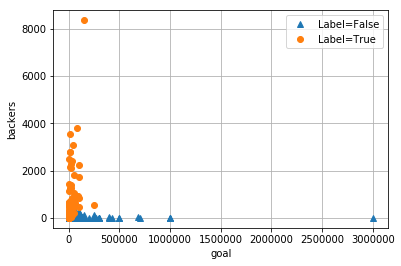

In [4]:
# グラフを描写して線形分離できそうか確認する(この後も何度か使うので関数化しておこう)
def myplot(X, y):
  d0 = X[y == False]
  d1 = X[y == True]

  plt.grid(True)
  plt.xlabel('goal')
  plt.ylabel('backers')
  plt.plot(d0['goal'], d0['backers'], '^', color='C0', label='Label=False')
  plt.plot(d1['goal'], d1['backers'], 'o', color='C1', label='Label=True')
  plt.legend(loc='best')

myplot(X, y)

### まずはそのままロジスティック回帰

In [5]:
# scikit-learnのSGDClassifierを使う
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)

# 学習
clf.fit(X, y)

print('重み')
display(clf.intercept_[0])
display(clf.coef_[0])

# 予測
y_est = clf.predict(X)

# 結果の確認(この後も何度か使うので関数化しておこう)
def check_result(y, y_est):

  print('対数尤度')
  display(-log_loss(y, y_est))

  print('正答率')
  print('Accuracy:\t{:.2%}'.format(accuracy_score(y, y_est)))
  print('Precision:\t{:.2%}'.format(precision_score(y, y_est)))
  print('Recall:\t{:.2%}\n'.format(recall_score(y, y_est)))

  print('予測値と正解のクロス集計表')
  conf_mat = pd.DataFrame(confusion_matrix(y, y_est),
                        index=['正解 = 0', '正解 = 1'],
                        columns=['予測値 = 0', '予測値 = 1'])
  display(conf_mat)

check_result(y, y_est)

重み


188.20765047511517

array([  -5476.34049457, 1417982.05246558])

対数尤度


-4.110199947919403

正答率
Accuracy:	88.10%
Precision:	79.22%
Recall:	97.14%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,473,107
正解 = 1,12,408


### ホールドアウト法

In [6]:
# 学習用データとテストデータを分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

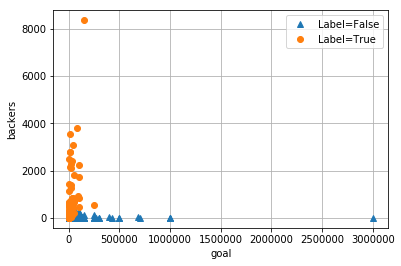

In [7]:
# 学習用データの分布
myplot(X_train, y_train)

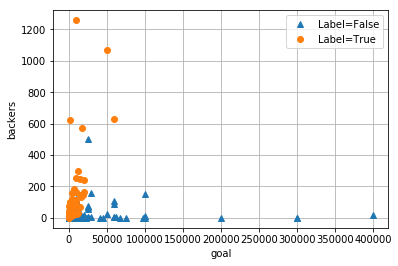

In [8]:
# テスト用データの分布
myplot(X_test, y_test)

In [9]:
# scikit-learnのSGDClassifierで学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)

print('重み')
display(clf.intercept_[0])
display(clf.coef_[0])

重み


1210.0697368461842

array([  -6182.13507637, 1658792.82697299])

In [10]:
# 訓練誤差
y_train_est = clf.predict(X_train)
check_result(y_train, y_train_est)

対数尤度


-3.842518833676834

正答率
Accuracy:	88.88%
Precision:	80.77%
Recall:	97.39%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,375,80
正解 = 1,9,336


In [11]:
# 汎化誤差
y_test_est = clf.predict(X_test)
check_result(y_test, y_test_est)

対数尤度


-5.6990180447747925

正答率
Accuracy:	83.50%
Precision:	70.59%
Recall:	96.00%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,95,30
正解 = 1,3,72


### 交差検証(クロスバリデーション)法

Python: pandas の DataFrame を scikit-learn で KFold するときの注意点
https://blog.amedama.jp/entry/2018/06/21/235951

In [24]:
# この後何回か繰り返して使うので一連の処理を関数化しておくと幸せになれそう
# （ハイパーパラメータも引数で渡せるといいかもね）
def kfold_sgdc(X, y):
    
    # 汎化誤差を格納しておくDataFrameを用意する
    scores = pd.DataFrame()

    # テスト役を交代させながら学習と評価を繰り返す
    kf = KFold(n_splits=5, random_state=1234)
    for train_index, test_index in kf.split(X):

        # KFoldより与えられたindexを使ってDataFrameからデータを取り出す
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        # scikit-learnのSGDClassifierで学習
        clf = SGDClassifier(loss='log', penalty='none', max_iter=10000,
                            fit_intercept=True, random_state=1234)
        clf.fit(X_train, y_train)

        # 汎化誤差を記録する
        y_est = clf.predict(X_test)
        scores = scores.append({
            '1.対数尤度(LogisticLoss)': -log_loss(y_test, y_est),
            '2.正確度(Accuracy)': accuracy_score(y_test, y_est),
            '3.適合度(Precision)': precision_score(y_test, y_est),
            '4.再現度(Recall)': recall_score(y_test, y_est)
        }, ignore_index=True)

    # 結果をまとめて確認する。全体の性能は平均値(mean)を見る
    display(scores)
    display(scores.describe())

# 上記で関数として定義した一連の処理を実行
kfold_sgdc(X, y)

,1.対数尤度(LogisticLoss),2.正確度(Accuracy),3.適合度(Precision),4.再現度(Recall)
0,-3.108554,0.910,0.846154,0.977778
1,-4.835517,0.860,0.782178,0.929412
2,-3.626651,0.895,0.811321,0.988506
3,-3.972043,0.885,0.798077,0.976471
4,-5.180932,0.850,0.712871,0.986301


,1.対数尤度(LogisticLoss),2.正確度(Accuracy),3.適合度(Precision),4.再現度(Recall)
count,5.000000,5.000000,5.000000,5.000000
mean,-4.144740,0.880000,0.790120,0.971693
std,0.854808,0.024749,0.049201,0.024206
min,-5.180932,0.850000,0.712871,0.929412
25%,-4.835517,0.860000,0.782178,0.976471
50%,-3.972043,0.885000,0.798077,0.977778
75%,-3.626651,0.895000,0.811321,0.986301
max,-3.108554,0.910000,0.846154,0.988506


## 欠損値と異常値への対応

In [95]:
# 実験用のデータを用意する
df3 = df.head(10000)

# フィールド名は付け直しておく
df3 = df3.rename(columns={
    'ID ': 'id', 'name ': 'name', 'category ': 'category', 'main_category ': 'main_category', 'currency ': 'currency',
    'deadline ': 'deadline', 'goal ': 'goal', 'launched ': 'launched', 'pledged ': 'pledged', 'state ': 'state',
    'backers ': 'backers', 'country ': 'country', 'usd pledged ': 'usd_pledged'})

In [96]:
# 欠損値の確認
display(df3.isnull().sum())

id                   0
name                 0
category             0
main_category        0
currency             0
deadline             0
goal                 0
launched             0
pledged              0
state                0
backers              0
country              0
usd_pledged        121
Unnamed: 13       9985
Unnamed: 14      10000
Unnamed: 15      10000
Unnamed: 16      10000
dtype: int64

In [97]:
# 列数が合っていないものはパースエラーなので除外する

# 念のため確認
display(df3[df3['usd_pledged'].isnull()].head()) # "N,""0"
display(df3[df3['Unnamed: 13'].notnull()].head()) # nameにカンマ

# 除外
df3 = df3[df3['usd_pledged'].notnull()]
df3 = df3[df3['Unnamed: 13'].isnull()]

# 改めて欠損値を確認
display(df3.isnull().sum())

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
150,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20 06:59:00,6500,2014-08-06 21:28:36,555,undefined,0,"N,""0",NaN,NaN,NaN,NaN,NaN
287,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25 23:00:00,4500,2015-08-04 12:05:17,4767,undefined,0,"N,""0",NaN,NaN,NaN,NaN,NaN
549,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09 21:06:13,3500,2015-03-10 20:06:13,3576,undefined,0,"N,""0",NaN,NaN,NaN,NaN,NaN
561,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26 10:59:00,6000,2015-11-02 22:09:19,7007.8,undefined,0,"N,""0",NaN,NaN,NaN,NaN,NaN
650,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21 06:00:00,3000,2016-02-23 03:09:49,3660.38,undefined,0,"N,""0",NaN,NaN,NaN,NaN,NaN


,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
1454,1008705746,Zephyra´s new full length,'As The World Collapses',Metal,Music,SEK,2016-02-02 00:56:46,15000,2016-01-03 00:56:46,4262,failed,14,SE,504.94765278,NaN,NaN,NaN
1563,1009317190,French Cuisine,A Traditional Experience,Cookbooks,Food,USD,2014-09-08 00:46:23,13730,2014-08-09 03:16:02,3984,failed,46,US,3984,NaN,NaN,NaN
1794,1010871699,The Beginners Guide to being Unsuicidal,the one act,Theater,Theater,USD,2011-12-31 23:25:46,5000,2011-11-21 23:25:46,525,failed,10,US,525,NaN,NaN,NaN
1931,1011687764,Best OnLine Classifieds,Ever / No More Spam,Web,Technology,USD,2014-09-20 19:56:10,6300,2014-08-21 19:56:10,0,failed,0,US,0,NaN,NaN,NaN
2420,101453314,Social Media Ruined My Life,A Short Film from Adam S Curtis,Shorts,Film & Video,USD,2013-03-14 20:11:57,3000,2013-02-25 21:11:57,3035,successful,42,US,3035,NaN,NaN,NaN


id                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd_pledged         0
Unnamed: 13      9864
Unnamed: 14      9864
Unnamed: 15      9864
Unnamed: 16      9864
dtype: int64

In [98]:
# stateの中身を確認
df3['state'].value_counts()

# 成否が明確なもの以外は使わない
df3 = df3[df3['state'].isin(['successful', 'failed'])]

# 目的関数は1/0で表す
df3['obj'] = df3['state'] == 'successful'

In [99]:
# ここまでのフィルタリングするとノイズがなくなるので型変換が通るようになる
df3 = df3.astype({'goal': float, 'pledged': float, 'backers': float, 'usd_pledged': float})

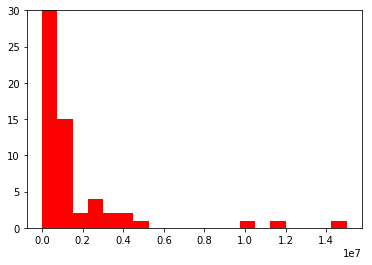

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,obj
2708,1016210580,INDIRA – THE FIRST INDIAN GRAND MUSICAL,Musical,Theater,EUR,2016-04-27 13:08:01,15000000.0,2016-02-27 13:08:01,15.0,failed,6.0,ES,16.593655,NaN,NaN,NaN,NaN,False
6436,1037984441,Irie Jamboree - My life in Jamaica...,Film & Video,Film & Video,SEK,2015-04-05 08:08:28,12000000.0,2015-02-04 08:08:28,8.0,failed,1.0,SE,0.963898,NaN,NaN,NaN,NaN,False
7852,1046235166,Duel,Science Fiction,Film & Video,USD,2016-03-06 15:00:11,10000000.0,2016-01-06 15:00:11,100.0,failed,2.0,US,100.000000,NaN,NaN,NaN,NaN,False
2577,1015466274,Genesis,Film & Video,Film & Video,EUR,2015-09-01 23:55:00,5000000.0,2015-07-07 21:14:52,0.0,failed,0.0,IT,0.000000,NaN,NaN,NaN,NaN,False
8007,1047060472,"E.T Scooter , World's most innovative electric...",Technology,Technology,SEK,2014-12-12 19:59:29,4000000.0,2014-11-12 19:59:29,35.0,failed,2.0,SE,4.717757,NaN,NaN,NaN,NaN,False


In [100]:
# goal について
k = 'goal'

#ヒストグラムで確認
ax=plt.subplot()
ax.hist(df3[k], bins=20, color='r')
ax.set_ylim([0, 30])
plt.show()

# 極端に大きい値を実データを目視確認
df3.sort_values(k, ascending=False).head()
# 特におかしなデータではなさそう
# 標準化して使おう

# 標準化するならこう。学習データとテストデータを分離してからやる必要がある
# df3[k + '_sc'] = StandardScaler().fit_transform(df3[[k]].values)

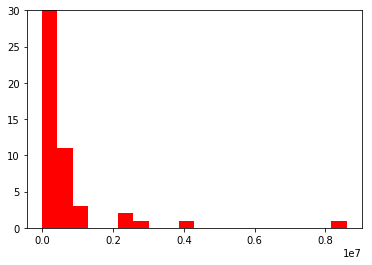

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,obj
5704,1033978702,OUYA: A New Kind of Video Game Console,Gaming Hardware,Games,USD,2012-08-09 07:00:00,950000.0,2012-07-10 14:44:41,8596474.58,successful,63416.0,US,8.596475e+06,NaN,NaN,NaN,NaN,True
7726,1045500705,Zombicide: Black Plague,Tabletop Games,Games,USD,2015-07-07 02:00:00,125000.0,2015-06-08 20:59:38,4079204.52,successful,20915.0,US,4.079205e+06,NaN,NaN,NaN,NaN,True
8530,1050139758,KULT: Divinity Lost - Horror Roleplaying Game ...,Tabletop Games,Games,SEK,2016-03-31 23:00:00,95000.0,2016-02-25 15:01:18,2746655.75,successful,2733.0,SE,3.235310e+05,NaN,NaN,NaN,NaN,True
4743,1028274367,Oculus Rift: Step Into the Game,Gaming Hardware,Games,USD,2012-09-01 08:00:00,250000.0,2012-08-01 16:51:23,2437429.75,successful,9522.0,US,2.437430e+06,NaN,NaN,NaN,NaN,True
2958,101767263,3Doodler: The World's First 3D Printing Pen,Hardware,Technology,USD,2013-03-25 05:08:59,30000.0,2013-02-19 06:08:59,2344134.67,successful,26457.0,US,2.344135e+06,NaN,NaN,NaN,NaN,True


In [101]:
# pledged について
k = 'pledged'

#ヒストグラムで確認
ax=plt.subplot()
ax.hist(df3[k], bins=20, color='r')
ax.set_ylim([0, 30])
plt.show()

# 極端に大きい値を実データを目視確認
df3.sort_values(k, ascending=False).head()
# 特におかしなデータではなさそう
# 標準化して使おう

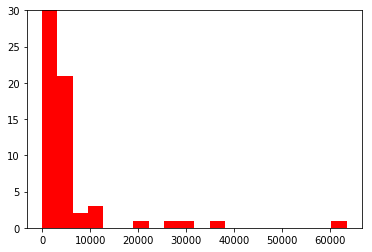

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,obj
5704,1033978702,OUYA: A New Kind of Video Game Console,Gaming Hardware,Games,USD,2012-08-09 07:00:00,950000.0,2012-07-10 14:44:41,8596474.58,successful,63416.0,US,8596474.58,NaN,NaN,NaN,NaN,True
3794,1022576045,Polygons | The Flat 4-in-1 Measuring Spoon,Product Design,Design,USD,2016-11-20 17:57:34,10000.0,2016-10-11 17:57:34,1022120.70,successful,36863.0,US,135121.00,NaN,NaN,NaN,NaN,True
8528,1050138201,Pressy - the Almighty Android Button!,Product Design,Design,USD,2013-10-14 21:22:37,40000.0,2013-08-28 21:22:37,695138.50,successful,28818.0,US,695138.50,NaN,NaN,NaN,NaN,True
2958,101767263,3Doodler: The World's First 3D Printing Pen,Hardware,Technology,USD,2013-03-25 05:08:59,30000.0,2013-02-19 06:08:59,2344134.67,successful,26457.0,US,2344134.67,NaN,NaN,NaN,NaN,True
7726,1045500705,Zombicide: Black Plague,Tabletop Games,Games,USD,2015-07-07 02:00:00,125000.0,2015-06-08 20:59:38,4079204.52,successful,20915.0,US,4079204.52,NaN,NaN,NaN,NaN,True


In [102]:
# backers について
k = 'backers'

#ヒストグラムで確認
ax=plt.subplot()
ax.hist(df3[k], bins=20, color='r')
ax.set_ylim([0, 30])
plt.show()

# 極端に大きい値を実データを目視確認
df3.sort_values(k, ascending=False).head()
# 特におかしなデータではなさそう
# 標準化して使おう

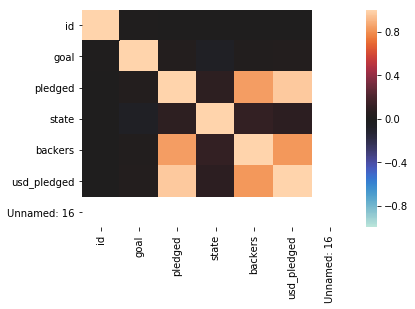

In [69]:
# 相関関係をヒートマップで可視化
sns.heatmap(df3.corr(), vmax=1, vmin=-1, center=0)
plt.show()

相関係数: 0.842


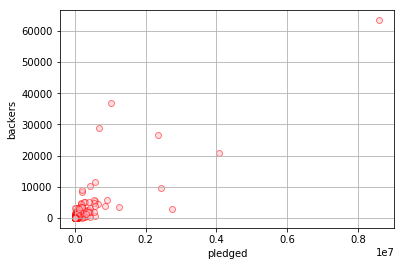

In [70]:
# pledged と backers は相関係数が強いことが分かる
print('相関係数: {:.3f}'.format(np.corrcoef(df3['pledged'], df3['backers'])[0,1]))

# 散布図で見る
plt.scatter(df3['pledged'], df3['backers'], c="pink", alpha=0.5, linewidths="1", edgecolors="red")
plt.grid(True)
plt.xlabel('pledged')
plt.ylabel('backers')
plt.show()

# 確かに相関関係がありそう
# 無相関化しよう

#  無相関化を行うための一連の処理
#cov = np.cov(data1, rowvar=0) # 分散・共分散を求める
#_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
#data1_decorr = np.dot(S.T, data1.T).T #データを無相関化

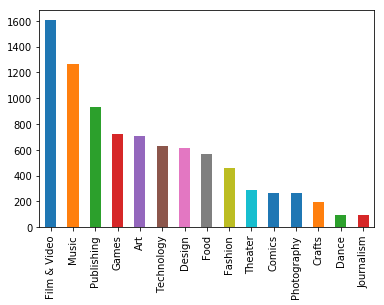

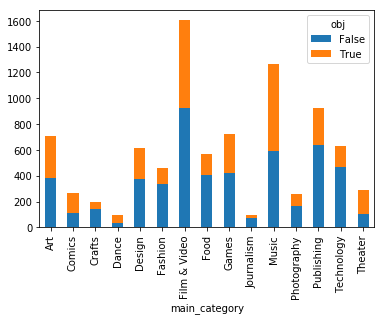

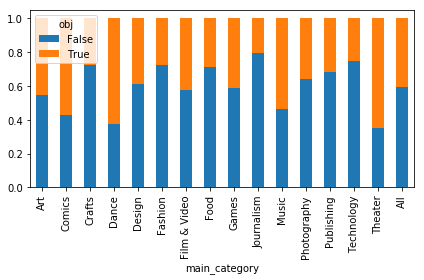

In [103]:
# main_categoryをクロス集計表で確認
df3['main_category'].value_counts().plot(kind="bar")
pd.crosstab(df3['main_category'], df3['obj']).plot(kind="bar", stacked=True)
pd.crosstab(df3['main_category'], df3['obj'], margins=True, normalize='index').plot(kind="bar", stacked=True)
plt.tight_layout()
plt.show()
# ダミー変数化して使おう

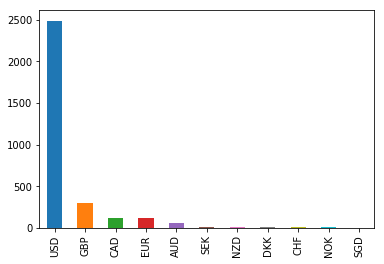

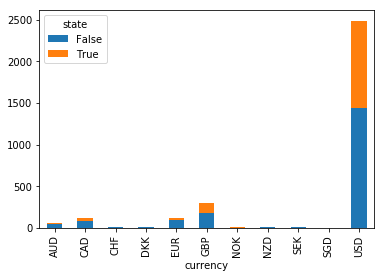

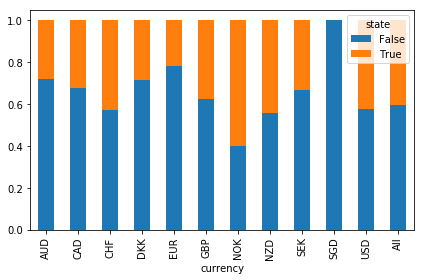

In [22]:
# currencyをクロス集計表で確認
df3['currency'].value_counts().plot(kind="bar")
pd.crosstab(df3['currency'], df3['state']).plot(kind="bar", stacked=True)
pd.crosstab(df3['currency'], df3['state'], margins=True, normalize='index').plot(kind="bar", stacked=True)
plt.tight_layout()
plt.show()
# ダミー変数化して使おう

ここまでを踏まえて実行結果を比較してみる

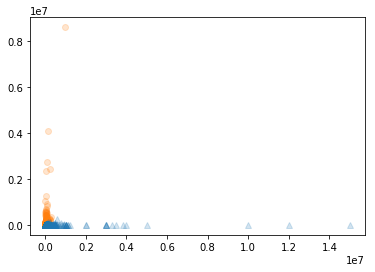

In [105]:
plt.plot(df3[df3['obj']]['goal'], df3[df3['obj']]['pledged'], 'o', color='C1', alpha=0.2)
plt.plot(df3[~df3['obj']]['goal'], df3[~df3['obj']]['pledged'], '^', color='C0', alpha=0.2)

In [139]:
# まずはこれらのフィールドをそのまま使う
X1 = df3[['goal', 'backers']] # pledgedは封印
y1 = df3['obj']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1234)
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X1_train, y1_train)
y1_est = clf.predict(X1_test)
check_result(y1_test, y1_est)

対数尤度


-3.360485639139478

正答率
Accuracy:	90.27%
Precision:	82.84%
Recall:	95.55%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,902,138
正解 = 1,31,666


In [142]:
# 前述のデータをコピーしてここに手を加えていく
X2_train = X1_train.copy()
y2_train = y1_train.copy()
X2_test = X1_test.copy()
y2_test = y1_test.copy()

# 学習データを無相関化
# （元々相関関係は強くないんだけど、まぁ一応やり方を確認しておこう）
cov = np.cov(X1_train, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov) # 分散共分散行列の固有ベクトルを用いて
decorr = np.dot(S.T, X1_train.T).T # 学習データを無相関化
X2_train['goal'] = decorr[:, 0]
X2_train['backers'] = decorr[:, 1]
print('相関係数: {:.3f}'.format(np.corrcoef(X1_train['goal'], X1_train['backers'])[0,1]))
print('相関係数: {:.3f}'.format(np.corrcoef(X2_train['goal'], X2_train['backers'])[0,1]))

# 学習データから取得した固有ベクトルを用いてテストデータを無相関化
decorr = np.dot(S.T, X1_test.T).T
X2_test['goal'] = decorr[:, 0]
X2_test['backers'] = decorr[:, 1]
print('相関係数: {:.3f}'.format(np.corrcoef(X1_test['goal'], X1_test['backers'])[0,1]))
print('相関係数: {:.3f}'.format(np.corrcoef(X2_test['goal'], X2_test['backers'])[0,1]))

相関係数: 0.033
相関係数: 0.000
相関係数: 0.013
相関係数: -0.006


In [143]:
# 無相関化したデータで学習＆汎化性能評価
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X2_train, y2_train)
y2_est = clf.predict(X2_test)
check_result(y2_test, y2_est)

対数尤度


-3.360485639139478

正答率
Accuracy:	90.27%
Precision:	82.84%
Recall:	95.55%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,902,138
正解 = 1,31,666


案の定ほとんど結果は変わらない

* TODO1: 標準化
* TODO2: 質的変数をダミー変数化